In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
# from pyjet import cluster
from pyjet import cluster,DTYPE_PTEPM
from pyjet.testdata import get_event
import h5py as h5

In [2]:
outfile = "data/events_anomalydetection.h5"
hf = h5.File(outfile, 'r')
print(hf["df"].keys())

<KeysViewHDF5 ['axis0', 'axis1', 'block0_items', 'block0_values']>


In [3]:
keys = list(hf["df"].keys())


In [4]:
keys = list(hf["df"].keys())
for key in keys:
    print(hf["df"][key])

<HDF5 dataset "axis0": shape (2101,), type "<i8">
<HDF5 dataset "axis1": shape (1100000,), type "<i8">
<HDF5 dataset "block0_items": shape (2101,), type "<i8">
<HDF5 dataset "block0_values": shape (1100000, 2101), type "<f8">


In [5]:
# Only load the first couple events
size = 10000

df = pd.read_hdf(outfile, "df", stop=size)
print(df.shape)
print("Memory in GB:",sum(df.memory_usage(deep=True)) / (1024**3))

(10000, 2101)
Memory in GB: 0.15661120414733887


In [6]:
df.shape

(10000, 2101)

In [7]:
events_combined = df.T

In [8]:
events_combined.shape

(2101, 10000)

In [9]:
leadpT = {}
leadeta = {}
leadphi = {}
leadmass = {}

subleadpT = {}
subleadeta = {}
subleadphi = {}
subleadmass = {}

alljets = {}
N = size # number of events

for mytype in ['background','signal']:
    leadpT[mytype]=[]
    leadeta[mytype]=[]
    leadphi[mytype]=[]
    leadmass[mytype]=[]
    
    subleadpT[mytype]=[]
    subleadeta[mytype]=[]
    subleadphi[mytype]=[]
    subleadmass[mytype]=[]
    
    alljets[mytype]=[]

    for i in tqdm(range(N)):
        issignal = events_combined[i][2100] # signal flag
        if (mytype=='background' and issignal):
            continue
        elif (mytype=='signal' and issignal==0):
             continue
        pseudojets_input = np.zeros(len([x for x in events_combined[i][::3] if x > 0]), dtype=DTYPE_PTEPM) # nontrivial particles in event i
        for j in range(700):
            if (events_combined[i][j*3]>0):
                pseudojets_input[j]['pT'] = events_combined[i][j*3]
                pseudojets_input[j]['eta'] = events_combined[i][j*3+1]
                pseudojets_input[j]['phi'] = events_combined[i][j*3+2]
            else:
                break

        sequence = cluster(pseudojets_input, R=1.0, p=-1) # anti-kT
        jets = sequence.inclusive_jets(ptmin=1200)
        
        if len(jets) > 1:
            leadpT[mytype] += [jets[0].pt]
            leadeta[mytype] += [jets[0].eta]
            leadphi[mytype] += [jets[0].phi]
            leadmass[mytype] += [jets[0].mass]
            subleadpT[mytype] += [jets[1].pt]
            subleadeta[mytype] += [jets[1].eta]
            subleadphi[mytype] += [jets[1].phi]
            subleadmass[mytype] += [jets[1].mass]
            alljets[mytype] += [jets]
        pass

100%|██████████| 10000/10000 [00:04<00:00, 2410.08it/s]


In [10]:
bg_lead = np.array([leadpT['background'],leadeta['background'],leadphi['background'],leadmass['background']])
bg_sublead = np.array([subleadpT['background'],subleadeta['background'],subleadphi['background'],subleadmass['background']])
signal_lead = np.array([leadpT['signal'],leadeta['signal'],leadphi['signal'],leadmass['signal']])
signal_sublead = np.array([subleadpT['signal'],subleadeta['signal'],subleadphi['signal'],subleadmass['signal']])


In [11]:
print(bg_lead.shape)
print(bg_sublead.shape)
print(signal_lead.shape)
print(signal_sublead.shape)

(4, 5647)
(4, 5647)
(4, 818)
(4, 818)


In [12]:
m1 = signal_lead[3,:]
m2 = signal_sublead[3,:]

In [13]:
pt1 = signal_lead[0,:]
pt2 = signal_sublead[0,:]
eta1 = signal_lead[1,:]
eta2 = signal_sublead[1,:]

In [14]:
E1 = np.sqrt(m1**2 + (pt1**2) * (np.cosh(eta1)**2))
E2 = np.sqrt(m2**2 + (pt2**2) * (np.cosh(eta2)**2))

In [18]:
# Calculate W' properties

E = E1 + E2

def add_momenta(p1, p2):
    px = p1[0,:] * np.cos(p1[2,:]) + p2[0,:] * np.cos(p2[2,:])
    py = p1[0,:] * np.sin(p1[2,:]) + p2[0,:] * np.sin(p2[2,:])
    pz = p1[0,:] * np.sinh(p1[1,:]) + p2[0,:] * np.sinh(p2[1,:])
    pE = np.sqrt(p1[3,:] ** 2 + (p1[0,:] ** 2) * (np.cosh(p1[1,:]) ** 2)) + np.sqrt(p2[3,:] ** 2 + (p2[0,:] ** 2) * (np.cosh(p2[1,:]) ** 2))
    pT = np.sqrt(px**2 + py**2)
    eta = np.arcsinh(pz / pT)
    phi = np.arctan2(py, px)
    m = np.sqrt(pE ** 2 - (pT * np.cosh(eta)) ** 2)
    return np.stack((pT, eta, phi, m))

p = add_momenta(signal_lead, signal_sublead)
m = p[3,:]

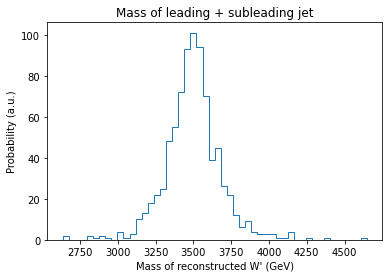

In [19]:
plt.title("Mass of leading + subleading jet")
plt.xlabel("Mass of reconstructed W' (GeV)")
plt.ylabel("Probability (a.u.)")
plt.hist(m, bins = "auto", histtype = "step")
plt.show()

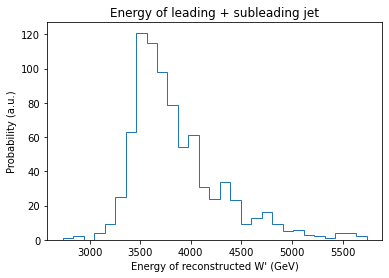

In [20]:
plt.title("Energy of leading + subleading jet")
plt.xlabel("Energy of reconstructed W' (GeV)")
plt.ylabel("Probability (a.u.)")
plt.hist(E, bins = "auto", histtype = "step")
plt.show()

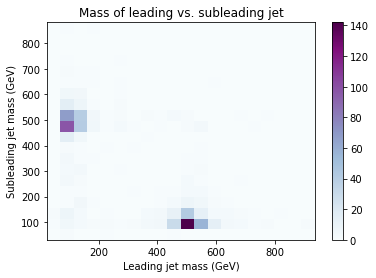

In [21]:
plt.title("Mass of leading vs. subleading jet")
plt.xlabel("Leading jet mass (GeV)")
plt.ylabel("Subleading jet mass (GeV)")
plt.hist2d(m1, m2, bins=20, cmap="BuPu")
plt.colorbar()
plt.show()

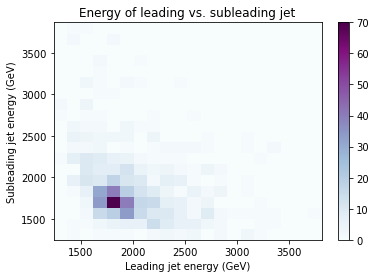

In [22]:
plt.title("Energy of leading vs. subleading jet")
plt.xlabel("Leading jet energy (GeV)")
plt.ylabel("Subleading jet energy (GeV)")
plt.hist2d(E1, E2, bins=20, cmap="BuPu")
plt.colorbar()
plt.show()